In [59]:
import pandas as pd
import altair as alt
import warnings
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

warnings.filterwarnings('ignore',category=DeprecationWarning)
warnings.simplefilter('ignore')

------------

# ALA List of Banned Books with Amazon URLs

In [60]:
banned_df = pd.read_csv('data/pen_dataset.csv')
banned_df = banned_df[['Title', 'Author', 'Type of Ban', 'State', 'District','Date of Challenge/Removal', 'Origin of Challenge', 'amazon_url']]

# Winter = Jan, Fall=Sept, before 1/22 = Dec 21
banned_df['Date of Challenge/Removal'] = banned_df['Date of Challenge/Removal'].replace(
    ['Winter 2021','Fall 2021','prior to 1/2022'],
    ['Jan 2021','September 2021','December 2021']
)

banned_df['Date of Challenge/Removal'] = pd.to_datetime(banned_df['Date of Challenge/Removal'])

banned_df = banned_df.rename(columns={
    'Title': 'title', 
    'Author': 'author',
    'Type of Ban': 'ban_type',
    'State': 'state',
    'District': 'school_district',
    'Date of Challenge/Removal': 'date_posted',
    'Origin of Challenge': 'origin_challenge'
})

banned_df.head()

title                  author  \
0       Ace of Spades  Àbíké-Íyímídé, Faridah   
1  Clap When You Land      Acevedo, Elizabeth   
2          The Poet X      Acevedo, Elizabeth   
3          The Poet X      Acevedo, Elizabeth   
4          The Poet X      Acevedo, Elizabeth   

                             ban_type         state  \
0  Banned in Libraries and Classrooms       Florida   
1                Banned in Classrooms  Pennsylvania   
2                 Banned in Libraries       Florida   
3  Banned in Libraries and Classrooms      New York   
4        Banned Pending Investigation         Texas   

                              school_district date_posted origin_challenge  \
0         Indian River County School District  2021-11-01    Administrator   
1                Central York School District  2021-09-01    Administrator   
2         Indian River County School District  2021-11-01    Administrator   
3            Marlboro Central School District  2022-02-01    Administrator   
4  Fredericksburg Independent School District  2022-03-01    Administrator   

                                          amazon_url  
0  https://www.amazon.com/Ace-Spades-Faridah-Abik...  
1  https://www.amazon.com/Clap-When-Land-Elizabet...  
2  https://www.amazon.com/Poet-X-Elizabeth-Aceved...  
3  https://www.amazon.com/Poet-X-Elizabeth-Aceved...  
4  https://www.amazon.com/Poet-X-Elizabeth-Aceved...

## Cleaning ALA Dataset

### Check for NaN Values

In [61]:
# Checking for null values
banned_df.isnull().sum()

title                 0
author                2
ban_type              0
state                 0
school_district       0
date_posted           0
origin_challenge      0
amazon_url          110
dtype: int64

#### We have 110 banned books that did not have Amazon reviews.

-------------

# Amazon Review Dataset 
## Processing & Cleaning

In [62]:
# Bring in Amazon book review dataset
amz_df = pd.read_csv('data/scraped_amz_reviews.csv')
amz_df.head()

product_name  \
0  Ace Spades Faridah Abike Iyimide   
1  Ace Spades Faridah Abike Iyimide   
2  Ace Spades Faridah Abike Iyimide   
3  Ace Spades Faridah Abike Iyimide   
4  Ace Spades Faridah Abike Iyimide   

                                               title  \
0  An Engrossing Page Turner About Race, Class an...   
1                               An Interesting Debut   
2                                                Wow   
3                              Definitely a YA novel   
4                                A most timely book.   

                                                body              rating  \
0  Granted, I've never been a fan of Gossip Girl ...  4.0 out of 5 stars   
1  “Hello, Niveus High. It’s me. Who am I? That’s...  4.0 out of 5 stars   
2  I ordered this book for my teenage daughter an...  5.0 out of 5 stars   
3  Great plot, childish characterizations (althou...  4.0 out of 5 stars   
4  This a very engrossing story.  I was intrigued...  5.0 out of 5 stars   

   verified_purchase         review_date  
0               True        June 6, 2021  
1               True       June 14, 2021  
2               True  September 12, 2022  
3               True     August 10, 2022  
4               True        July 5, 2021

### Check for null values

In [63]:
# Checking for null values
amz_df.isnull().sum()

product_name           0
title                 20
body                 107
rating                 0
verified_purchase      0
review_date            0
dtype: int64

In [64]:
### Impute missing body text (review) and title
amz_df['title'] = amz_df['title'].fillna('Missing')
amz_df['body'] = amz_df['body'].fillna('Missing')

### Combine review titles + body column

In [65]:
amz_df['reviews'] = amz_df['title'] + " " + amz_df['body']
amz_df = amz_df.drop(['title', 'body'], axis=1)

### Clean rating column

In [66]:
# Grab the rating string
amz_df['rating'] = amz_df['rating'].astype(str).str[:1]

# Drop reviews without ratings
amz_df = amz_df[amz_df.rating != 'n']

# Cast rating as integer
amz_df['rating'] = amz_df['rating'].astype(int)

### Clean verified purchase column

In [67]:
# Convert verified purhcase to yes or no
amz_df['verified_purchase'] = amz_df['verified_purchase'].map({True: 'Yes', False: 'No'}) 

### Clean date column

In [68]:
# Convert date to datetime
amz_df['date'] = pd.to_datetime(amz_df['review_date'])

### Create ban time column (before or after first ban date)

In [69]:
# Get dataframe before ban
before_df = amz_df.loc[(amz_df['date'] < '2021-07-01')]
print('Before ban', len(before_df))

# Get dataframe after ban
after_df = amz_df.loc[(amz_df['date'] >= '2021-07-01')]
print('After ban', len(after_df))

Before ban 359179
After ban 25054


In [70]:
amz_df.head()

product_name  rating verified_purchase  \
0  Ace Spades Faridah Abike Iyimide       4               Yes   
1  Ace Spades Faridah Abike Iyimide       4               Yes   
2  Ace Spades Faridah Abike Iyimide       5               Yes   
3  Ace Spades Faridah Abike Iyimide       4               Yes   
4  Ace Spades Faridah Abike Iyimide       5               Yes   

          review_date                                            reviews  \
0        June 6, 2021  An Engrossing Page Turner About Race, Class an...   
1       June 14, 2021  An Interesting Debut “Hello, Niveus High. It’s...   
2  September 12, 2022  Wow I ordered this book for my teenage daughte...   
3     August 10, 2022  Definitely a YA novel Great plot, childish cha...   
4        July 5, 2021  A most timely book. This a very engrossing sto...   

        date  
0 2021-06-06  
1 2021-06-14  
2 2022-09-12  
3 2022-08-10  
4 2021-07-05

---------

# ALA EDA

In [71]:
alt.Chart(banned_df).mark_point().encode(
    x='count(ban_type):Q',
    y='ban_type:N',
    color='origin_challenge'
)

alt.Chart(...)

In [72]:
alt.Chart(banned_df).mark_point().encode(
    x='count(ban_type):Q',
    y='state:N',
    color='origin_challenge'
)

alt.Chart(...)

In [73]:
alt.Chart(banned_df).mark_bar().encode(
    x='date_posted:T',
    y='count(ban_type):Q',
    color='ban_type'
)

alt.Chart(...)

In [74]:
alt.Chart(banned_df).mark_bar().encode(
    x='count(ban_type):Q',
    y='state',
    color='origin_challenge'
)

alt.Chart(...)

--------------

# Amazon EDA

Text(0, 0.5, 'Number of Reviews')

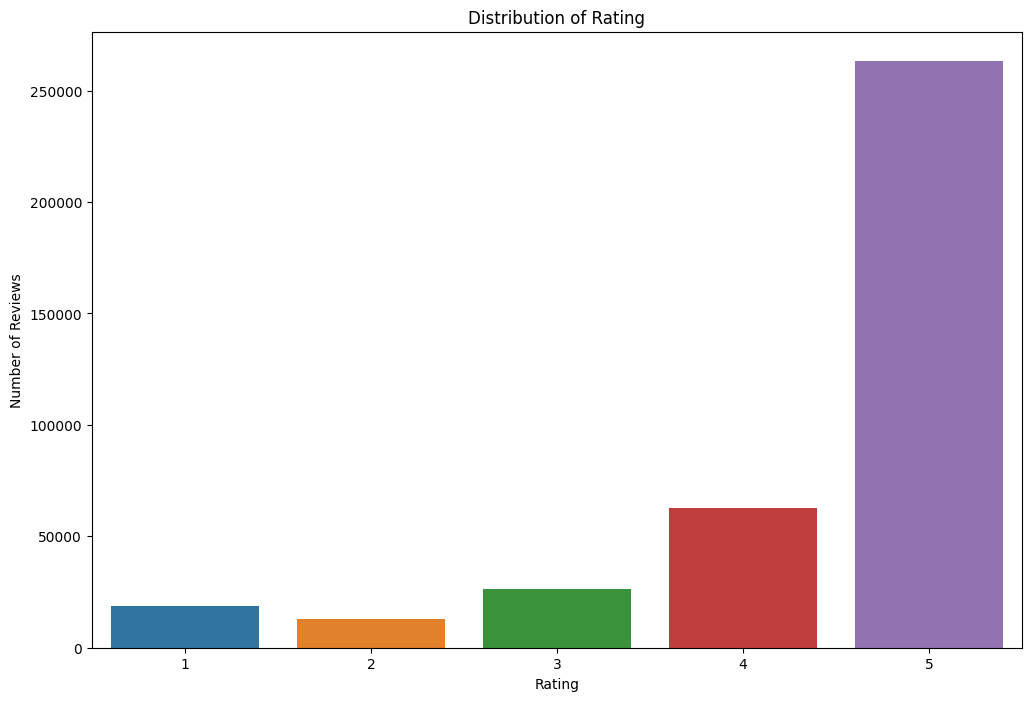

In [75]:
plt.figure(figsize=(12,8))
sns.countplot(data=amz_df, x='rating')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')